In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

In [2]:
delta = 0.05
beta = 20.0
N = 10
T = 1.0
Lambda = 1000.0
train_itr = 200

In [3]:
def rbf(x, beta):
    return jnp.exp(-beta*x**2)
d_rbf = jax.grad(rbf, argnums=0)

In [4]:
def rbf_func(x, theta):
    s = 0.
    for i in range(len(theta)):
        s +=theta[i] * rbf(x - delta*(i-1)+0.5, beta)
    return s

In [5]:
def d_rbf_func(x, theta):
    s = 0.
    for i in range(len(theta)):
        s += theta[i] * d_rbf(x - delta*(i-1)+0.5, beta)
    return s

In [6]:
def Integrate(T, N, Lambda, alpha, beta, theta):
    dt = T/N
    s = 0.
    r = np.random.rand()
    for i in range(N):
        y = rbf_func(i*dt, theta)
        y_d = d_rbf_func(i*dt, theta)
        F = -(y**2 - (1+alpha+beta*r)*y_d**2 + y*i*dt)
        s += F*dt
    s += Lambda*(rbf_func(0, theta) - 0.)**2 + Lambda*(rbf_func(1, theta) - 0.)**2
    return s

In [7]:
adam_lr = 1.
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

@partial(jax.jit, static_argnums=1)
def step(T, N, Lambda, alpha, beta, step_num, opt_state):
    value, grads = jax.value_and_grad(Integrate, argnums=-1)(T, N, Lambda, alpha, beta, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(T, N, alpha, beta, theta):
    opt_state = opt_init(theta)
    for itr in trange(train_itr, leave=False):
        value, opt_state = step(T, N, Lambda, alpha, beta, itr, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [8]:
theta_init = jnp.ones(50)
theta_trained = train(T, N, 0, 0, theta_init)

  0%|          | 0/200 [00:00<?, ?it/s]

loss:-0.007685353979468346  

In [9]:
ts = jnp.arange(0,1,1/50)
df = pd.DataFrame()
df["t"] = ts
df["Exact"] = [float(jnp.sin(t)/(2*jnp.sin(1.)) - t/2) for t in ts]
df["DU-RR (α=0,β=0)"] = [float(rbf_func(t, theta_trained)) for t in ts]

In [10]:
theta_trained = train(T, N, 1.0, 0, theta_init)

  0%|          | 0/200 [00:00<?, ?it/s]

2024-08-29 14:05:21.697901: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


loss:-0.00404214346781373    

2024-08-29 14:05:25.060993: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m3.363211182s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [11]:
df["DU-RR (α=1.0,β=0)"] = [float(rbf_func(t, theta_trained)) for t in ts]

In [12]:
theta_trained = train(T, N, 0, 1.0, theta_init)

  0%|          | 0/200 [00:00<?, ?it/s]

loss:-0.005957295186817646   

2024-08-29 14:08:04.602763: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m5.301188405s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [13]:
df["DU-RR (α=0,β=1.0)"] = [float(rbf_func(t, theta_trained)) for t in ts]

In [14]:
theta_trained = train(T, N, 0.5, 0, theta_init)

  0%|          | 0/200 [00:00<?, ?it/s]

loss:-0.0052467938512563705  

In [15]:
df["DU-RR (α=0.5,β=0)"] = [float(rbf_func(t, theta_trained)) for t in ts]

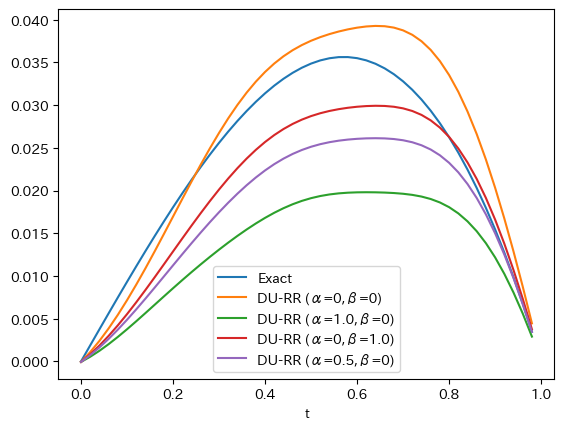

In [16]:
df.plot("t", df.columns[1:]);